In [ ]:
##Test

In [1]:
#Import Libraries
import requests
import json
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from numpy.random import seed

seed(1)
from tensorflow import random

random.set_seed(2)

In [3]:
from dotenv import load_dotenv
import os
load_dotenv()
API_KEY = os.getenv('GLASSNODE_API_KEY')

In [4]:
#Pull factors and BTC price from Glassnode Api
vol = requests.get('https://api.glassnode.com/v1/metrics/transactions/transfers_volume_sum',
    params={'a': 'BTC', 'api_key': API_KEY})

# convert to pandas dataframe
vol_df = pd.read_json(vol.text, convert_dates=['t'])

dorm = requests.get('https://api.glassnode.com/v1/metrics/indicators/average_dormancy',
    params={'a': 'BTC', 'api_key': API_KEY})

# convert to pandas dataframe
dormancy_df = pd.read_json(dorm.text, convert_dates=['t'])

# make API request
asopr = requests.get('https://api.glassnode.com/v1/metrics/indicators/sopr_adjusted',
    params={'a': 'BTC', 'api_key': API_KEY})

# convert to pandas dataframe
asopr_df = pd.read_json(asopr.text, convert_dates=['t'])
asopr_df.head()

# make API request
price_res = requests.get('https://api.glassnode.com/v1/metrics/market/price_usd_close',
    params={'a': 'BTC', 'api_key': API_KEY})

# convert to pandas dataframe
price_df = pd.read_json(price_res.text, convert_dates=['t'])

# make API request
exch_flow = requests.get('https://api.glassnode.com/v1/metrics/transactions/transfers_volume_exchanges_net',
    params={'a': 'BTC', 'api_key': API_KEY})

# convert to pandas dataframe
exch_df = pd.read_json(exch_flow.text, convert_dates=['t'])

# make API request
cdd = requests.get('https://api.glassnode.com/v1/metrics/indicators/cdd',
    params={'a': 'BTC', 'api_key': API_KEY})

# convert to pandas dataframe
cdd_df = pd.read_json(cdd.text, convert_dates=['t'])

# make API request
profit_relative = requests.get('https://api.glassnode.com/v1/metrics/supply/profit_relative',
    params={'a': 'BTC', 'api_key': API_KEY})

# convert to pandas dataframe
profit_relative_df = pd.read_json(profit_relative.text, convert_dates=['t'])


#convert to OHLCpandas dataframe
ohlc = requests.get('https://api.glassnode.com/v1/metrics/market/price_usd_ohlc',
                    params={'a': 'BTC', 'api_key': API_KEY})
j = ohlc.json()
ohlc_array=[]
for t in j:
    newdict={}
    newdict['t']=t['t']
    newdict['o']=t['o']['o']
    newdict['h']=t['o']['h']
    newdict['l']=t['o']['l']
    newdict['c']=t['o']['c']
    ohlc_array.append(newdict)
ohlc_df = pd.DataFrame(ohlc_array)
result = ohlc_df.to_json(orient="records")
ohlc_df = pd.read_json(result, convert_dates=['t'])



In [5]:
ohlc_df.rename(columns = {'t':'date', 'o':'open', 'h':'high', 'l':'low', 'c':'close'}, inplace=True)
ohlc_df.set_index('date', inplace=True)

In [6]:
vol_df.rename(columns = {'t':'date', 'v':'vol'}, inplace=True)
vol_df.set_index('date', inplace=True)


In [7]:
dormancy_df.rename(columns = {'t':'date', 'v':'dormancy'}, inplace=True)
dormancy_df.set_index('date', inplace=True)


In [8]:
asopr_df.rename(columns = {'t':'date', 'v':'asopr'}, inplace=True)
asopr_df.set_index('date', inplace=True)

In [9]:
price_df.rename(columns = {'t':'date', 'v':'price'}, inplace=True)
price_df.set_index('date', inplace=True)

In [10]:
exch_df.rename(columns = {'t':'date', 'v':'flow'}, inplace=True)
exch_df.set_index('date', inplace=True)

In [11]:
cdd_df.rename(columns = {'t':'date', 'v':'cdd'}, inplace=True)
cdd_df.set_index('date', inplace=True)

In [12]:
profit_relative_df.rename(columns = {'t':'date', 'v':'profit_relative_df'}, inplace=True)
profit_relative_df.set_index('date', inplace=True)

In [13]:
dataset = pd.concat([vol_df, dormancy_df, asopr_df, ohlc_df, exch_df, cdd_df,profit_relative_df], axis=1, join='inner')

In [14]:
dataset.dropna(inplace=True)

In [15]:
dataset.shape

(3559, 10)

In [15]:
data_new = dataset['2015-01-01':'2020-10-01']
data_new

,vol,dormancy,asopr,open,high,low,close,flow,cdd,profit_relative_df
date,,,,,,,,,,
2015-01-01,4.646205e+05,2.302504,0.987951,320.987415,320.987415,313.739880,314.025456,124.391488,9.468414e+05,0.454863
2015-01-02,7.280903e+05,2.879840,0.978582,313.973633,316.759759,312.847921,315.687161,790.763344,1.942400e+06,0.463323
2015-01-03,8.367299e+05,6.160422,0.923681,315.313701,316.529810,283.006535,283.006535,4634.540821,4.768928e+06,0.421309
2015-01-04,1.129690e+06,6.023914,0.915979,280.469412,288.253558,256.121596,263.807883,-897.057854,5.944678e+06,0.423702
2015-01-05,1.134569e+06,4.854263,0.901450,264.973697,279.195639,264.973697,276.800000,7898.518534,5.045935e+06,0.428064
...,...,...,...,...,...,...,...,...,...,...
2020-09-27,2.071286e+06,17.708307,1.005520,10743.831374,10803.277667,10647.165037,10774.426756,-1541.539621,5.974249e+06,0.850047
2020-09-28,2.292826e+06,8.726355,1.012117,10832.145213,10949.123149,10718.589184,10721.327041,-3380.920498,4.622663e+06,0.832459
2020-09-29,2.585598e+06,30.591008,1.027205,10710.473499,10856.108615,10666.480343,10848.830487,606.147281,1.903513e+07,0.851464


In [16]:
dataset

,vol,dormancy,asopr,open,high,low,close,flow,cdd,profit_relative_df
date,,,,,,,,,,
2011-08-17,3.230502e+05,2.860031,1.023796,10.943860,11.095782,10.686489,10.993067,0.007500,9.222607e+05,0.654183
2011-08-18,4.002768e+05,3.039587,1.018691,10.946207,11.030015,10.350000,10.847018,8.049029,1.214820e+06,0.633324
2011-08-19,5.561058e+05,1.548021,1.009232,10.869213,11.740022,10.802218,11.650000,39.591418,8.595439e+05,0.673411
2011-08-20,2.246163e+05,3.934542,1.026221,11.651622,11.656323,10.720000,11.450998,-8.048029,8.800028e+05,0.663196
2011-08-21,2.428926e+05,1.686685,0.993798,11.452000,11.499200,11.112000,11.323212,1.819000,4.080212e+05,0.658170
...,...,...,...,...,...,...,...,...,...,...
2021-05-09,1.085785e+06,22.308682,1.040930,58949.175691,59210.881789,56594.240801,58218.566077,7812.810506,9.067803e+06,0.948036
2021-05-10,1.412837e+06,16.661084,1.030398,58313.694230,59463.950585,54558.287582,55824.861667,4060.184188,1.016189e+07,0.876695
2021-05-11,1.204164e+06,14.106913,1.010814,55828.260785,56870.394152,54696.374470,56714.088910,-6094.859136,7.254929e+06,0.908097


In [17]:
# dataset['diff'] = dataset['price'].pct_change()
# dataset.drop(columns='price', inplace=True)
# dataset.dropna(inplace=True)
# dataset

In [18]:
def window_data(df, window, target_column, lag=0, target_as_feature=True):
    Xdf = df
    ydf = df[target_column]
    if target_as_feature == False:
        Xdf=Xdf.drop(columns=[target_column])
    X, y = [], []
    for i in range(len(Xdf)-window-lag):
        features = Xdf[i+lag:i+window+lag]
        X.append(features)
    for i in range(len(ydf)-window-lag):
        target = ydf[i+window+lag]
        y.append(target)
    return np.array(X), np.array(y).reshape(-1,1)
    
    

In [19]:
X, y = window_data(data_new, 15, "close", 0, True)

In [20]:
split = int(0.97 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

In [21]:
scalers = {}
for i in range(X_train.shape[1]):
    scalers[i] = MinMaxScaler()
    X_train[:, i, :] = scalers[i].fit_transform(X_train[:, i, :]) 
for i in range(X_test.shape[1]):
    X_test[:, i, :] = scalers[i].transform(X_test[:, i, :])

In [22]:
X_test.shape

(63, 15, 10)

In [23]:
sc = MinMaxScaler()
sc.fit(y)
y_train = sc.transform(y_train)
y_test = sc.transform(y_test)

In [24]:
#GRU model
model = Sequential()
epochs = 10
model.add(GRU(50, return_sequences=True, input_shape=(X_train.shape[1],10)))
model.add(Dropout(0.2))
model.add(GRU(32))
model.add(Dropout(0.2))
model.add(Dense(16))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss="mse", optimizer="adam")
fit = model.fit(X_train, y_train, batch_size=3, epochs = epochs, validation_split=.1)

Epoch 1/10
607/607 [==============================] - 8s 9ms/step - loss: 0.0239 - val_loss: 6.1117e-04
Epoch 2/10
607/607 [==============================] - 5s 8ms/step - loss: 0.0047 - val_loss: 6.0659e-04
Epoch 3/10
607/607 [==============================] - 5s 8ms/step - loss: 0.0030 - val_loss: 0.0084
Epoch 4/10
607/607 [==============================] - 5s 8ms/step - loss: 0.0034 - val_loss: 7.3073e-04
Epoch 5/10
607/607 [==============================] - 5s 8ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 6/10
607/607 [==============================] - 5s 8ms/step - loss: 0.0027 - val_loss: 7.4311e-04
Epoch 7/10
607/607 [==============================] - 5s 8ms/step - loss: 0.0026 - val_loss: 4.3379e-04
Epoch 8/10
607/607 [==============================] - 5s 8ms/step - loss: 0.0023 - val_loss: 3.9916e-04
Epoch 9/10
607/607 [==============================] - 5s 8ms/step - loss: 0.0027 - val_loss: 4.1158e-04
Epoch 10/10
607/607 [==============================] - 5s 8ms/step - los

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 15, 50)            9300      
_________________________________________________________________
dropout (Dropout)            (None, 15, 50)            0         
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                8064      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                528       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

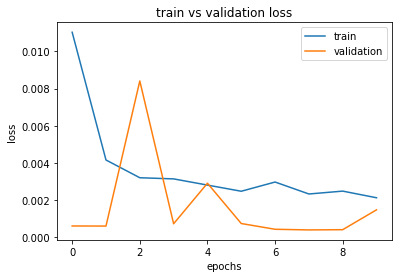

In [26]:
#Plot train vs validation loss
plt.plot(fit.history['loss'])
plt.plot(fit.history['val_loss'])
plt.title('train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [27]:
model.evaluate(X_test, y_test)

2/2 [==============================] - 0s 4ms/step - loss: 0.0020


0.0020332802087068558

In [28]:
predicted = model.predict(X_test)
predicted.shape

(63, 1)

In [29]:
mse = mean_squared_error(y_test, predicted)
mse

0.002033280034524527

In [30]:
np.sqrt(mse)

0.04509190653015824

In [31]:
predicted_close = sc.inverse_transform(predicted)
actual_close = sc.inverse_transform(y_test.reshape(-1, 1))

<AxesSubplot:xlabel='date'>

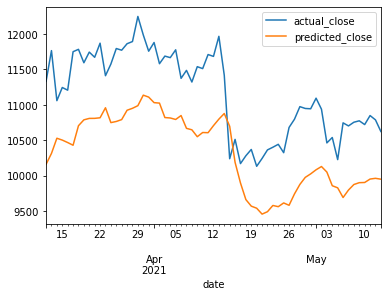

In [32]:
results_df = pd.DataFrame({
    'actual_close': actual_close.ravel(),
    "predicted_close": predicted_close.ravel()
    }, index = dataset.index[-len(actual_close): ])
results_df.plot()

In [33]:
results_prices_df = pd.concat([ohlc_df, results_df], axis=1, join='inner')
results_prices_df['predicted_perc_change'] = results_prices_df['predicted_close'].pct_change()
results_prices_df.dropna(inplace=True)
results_prices_df.reset_index(inplace=True)
results_prices_df.tail()

,date,open,high,low,close,actual_close,predicted_close,predicted_perc_change
57,2021-05-09,58949.175691,59210.881789,56594.240801,58218.566077,10774.426756,9899.776367,0.002646
58,2021-05-10,58313.694230,59463.950585,54558.287582,55824.861667,10721.327041,9902.447266,0.000270
59,2021-05-11,55828.260785,56870.394152,54696.374470,56714.088910,10848.830487,9950.916992,0.004895
60,2021-05-12,56701.747954,57907.816792,49916.494499,49916.494499,10787.617867,9961.370117,0.001050
61,2021-05-13,47376.082299,51264.958830,47337.445591,49729.302500,10623.330125,9949.061523,-0.001236


In [36]:
position=0
realized_profit = 0
unrealized_profit = 0 
profitable_transactions=0
unprofitable_transactions=0
transaction_list = []
data_size = len(results_prices_df.index)

for index, value in results_prices_df.iterrows():
    if index<data_size-1 and index > 0:
        
        open_price = results_prices_df.iloc[index]['open']
        close_price = results_prices_df.iloc[index]['close']
        yest_close_price = results_prices_df.iloc[index-1]['close']
        perc_change = results_prices_df.iloc[index]['predicted_perc_change']

        if position == 1:
            unrealized_profit = yest_close_price - buy_price
        if perc_change > 0:
            if position == 0:
                buy_price = open_price
                position = 1
        if perc_change < 0:
            if position ==1:
                sell_price = open_price
                position = 0
                trans_profit = sell_price-buy_price
                unrealized_profit = 0 
                realized_profit += trans_profit
                transaction_list.append({'Buy Price': buy_price, 'Sell Price': sell_price})
                if trans_profit>=0:
                    profitable_transactions+=1
                else:
                    unprofitable_transactions+=1

            
            
            
print(realized_profit)
print(unrealized_profit)
print(profitable_transactions)
print(unprofitable_transactions)
transaction_df = pd.DataFrame(transaction_list)
transaction_df['Return'] = transaction_df['Sell Price'] - transaction_df['Buy Price']
transaction_df['Cumulative Returns'] = transaction_df['Return'].cumsum()
transaction_df


2624.1000085881096
300.1353589852006
4
5


,Buy Price,Sell Price,Return,Cumulative Returns
0,61221.134297,59267.429049,-1953.705248,-1953.705248
1,59017.127972,54625.474213,-4391.653760,-6345.359008
2,52530.399667,58969.000845,6438.601179,93.242171
3,59268.318669,58176.499309,-1091.819360,-998.577189
4,58240.816898,59919.357709,1678.540810,679.963621
5,60296.393204,63411.565597,3115.172393,3795.136013
6,53857.106895,51143.226275,-2713.880620,1081.255393
7,50115.160572,49077.022208,-1038.138364,43.117029
8,54042.054388,56623.037367,2580.982980,2624.100009


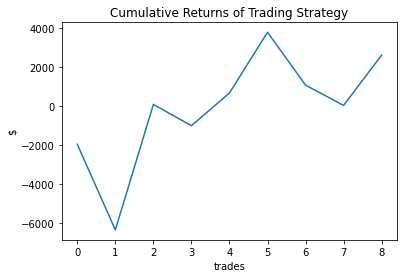

In [35]:
plt.plot(transaction_df['Cumulative Returns'])
plt.ylabel('$')
plt.xlabel('trades')
plt.title('Cumulative Returns of Trading Strategy')
plt.show()